<a href="https://colab.research.google.com/github/redom69/Programa-de-deteccion-de-pizzarras/blob/main/Programa_de_deteccion_de_pizzarras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math
from collections.abc import Iterable

#Imports necesarios

In [2]:
estructura = []  
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,table_number = 6,key_size = 12, multi_probe_level = 1) 
search_params = dict(checks=100) # Número máximo de hojas a visitar cuando se busca vecinos
flann = cv.FlannBasedMatcher(index_params,search_params)
descriptores = []
keypoint = []
diccionario = {}
diccContours = {}

#Inicializa todos los valores necesarios

In [3]:
def rellenarEstructura(kp,estructura):
  contkp = 0
  for keyPoint in kp:
    x = keyPoint.pt[0]
    y = keyPoint.pt[1]
    s = keyPoint.size
    angulo1 = keyPoint.angle
    xB= (w/2) - x
    yB =(h/2) - y
    modulo = math.sqrt((xB*xB)+(yB*yB))
    if(yB==0):
      angulo = np.arctan(xB/0.01)
    else:
      angulo = np.arctan(xB/yB)
    estructura.append([des[contkp],s,angulo1,modulo,angulo]) #list[list float float float float]
    plt.plot(x,y, marker="o", color="red")
    contkp = contkp + 1
#Funcion para ordenar los keypoints en un diccionario

train/recortada15.jpg


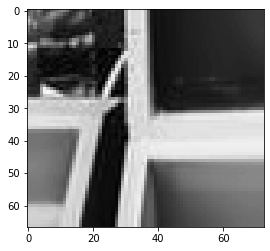

train/recortada29.3.jpg


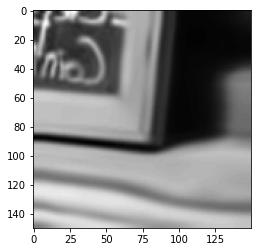

train/recortada67.jpg


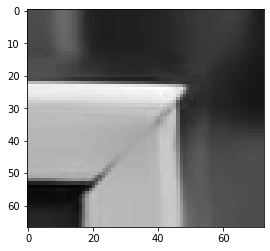

train/recortada54.3.jpg


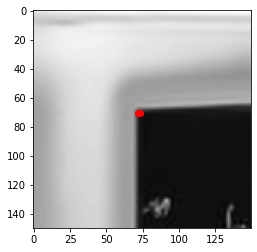

train/recortada24.2.jpg


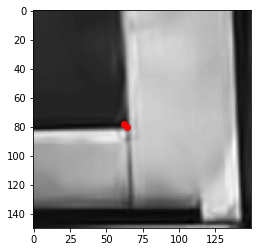

train/recortada65.2.jpg


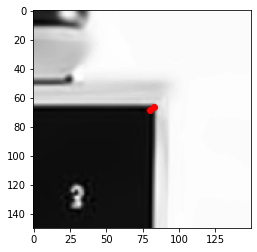

train/recortada12.jpg


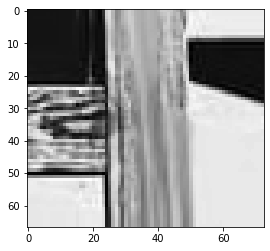

train/recortada64.jpg


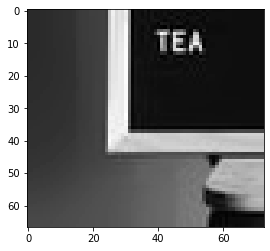

train/recortada84.jpg


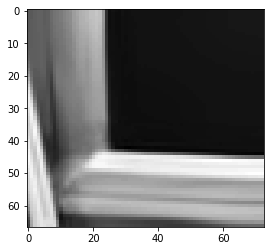

train/recortada31.1.jpg


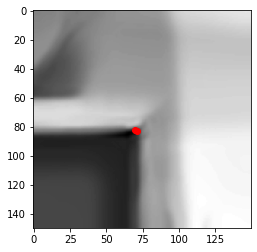

train/recortada46.2.jpg


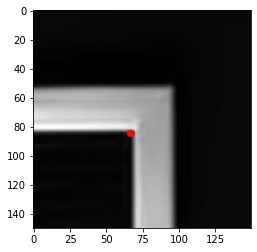

train/recortada82.jpg


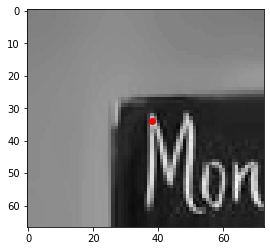

train/recortada5.jpg


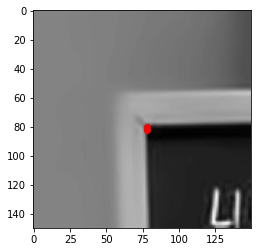

train/recortada63.1.jpg


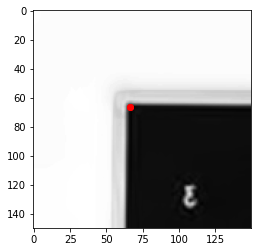

train/recortada56.jpg


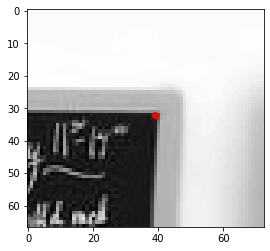

train/recortada6.2.jpg


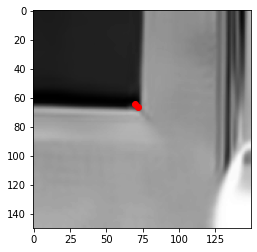

train/recortada45.1.jpg


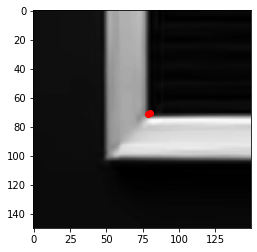

train/recortada11.jpg


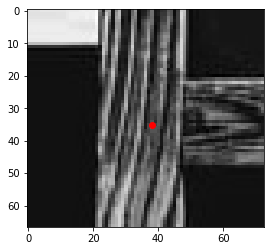

train/recortada7.jpg


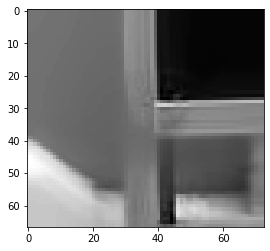

train/recortada43.2.jpg


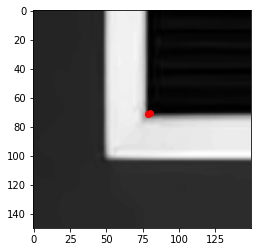

train/recortada65.1.jpg


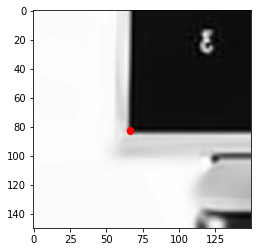

train/recortada5.1.jpg


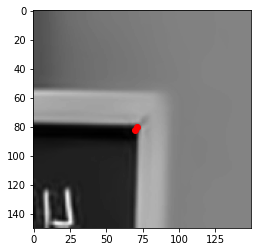

train/recortada28.jpg


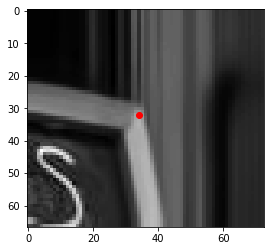

train/recortada51.2.jpg


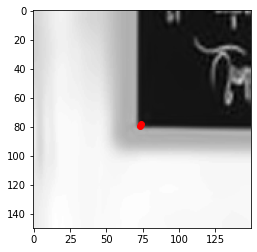

train/recortada48.jpg


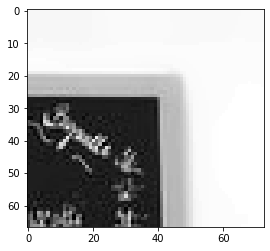

train/recortada44.jpg


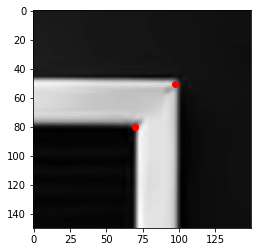

train/recortada3.jpg


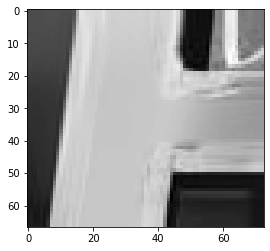

train/recortada46.3.jpg


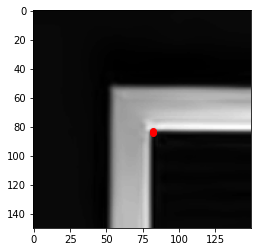

train/recortada92.jpg


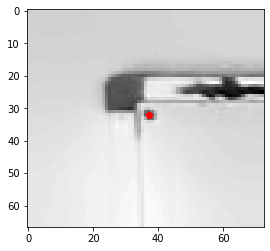

train/recortada39.2.jpg


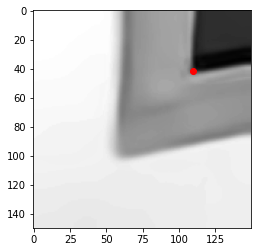

train/recortada86.jpg


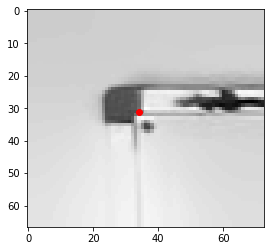

train/recortada58.jpg


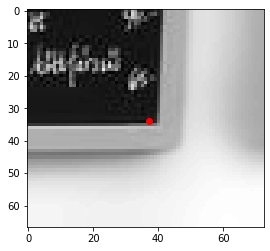

train/recortada51.1.jpg


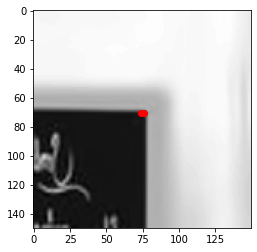

train/recortada31.2.jpg


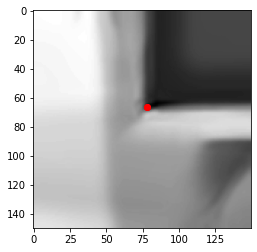

train/recortada2.jpg


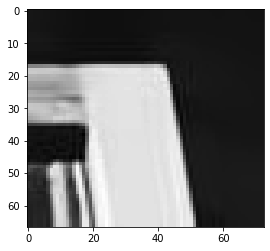

train/recortada24.jpg


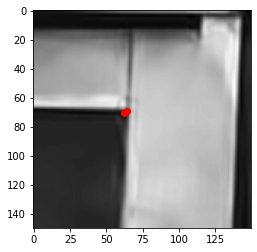

train/recortada59.jpg


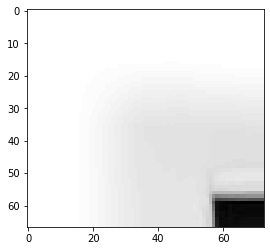

train/recortada43.3.jpg


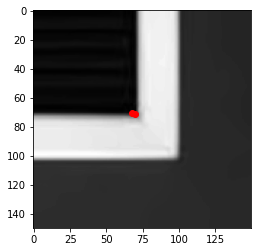

train/recortada13.jpg


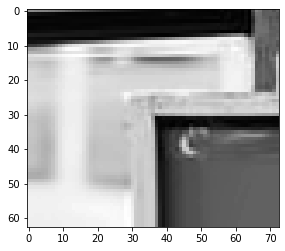

train/recortada39.3.jpg


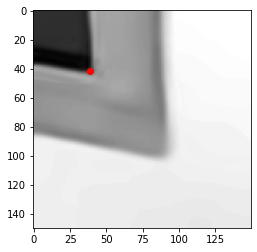

train/recortada78.jpg


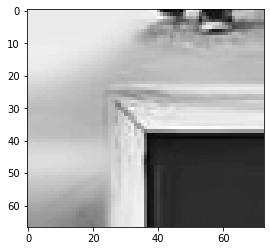

train/recortada30.jpg


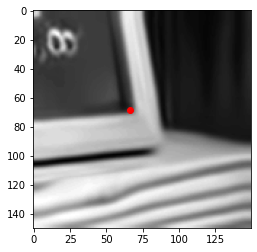

train/recortada23.jpg


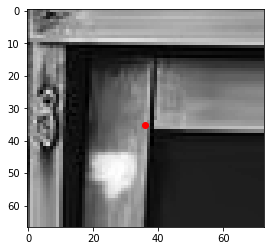

train/recortada42.jpg


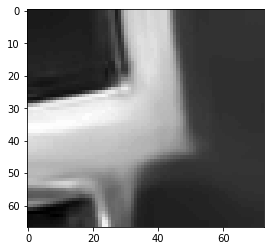

train/recortada61.2.jpg


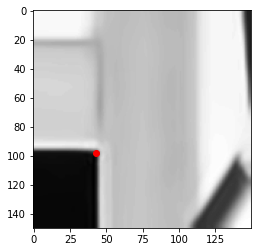

train/recortada14.jpg


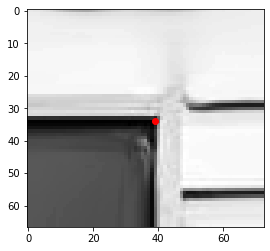

train/recortada5.2.jpg


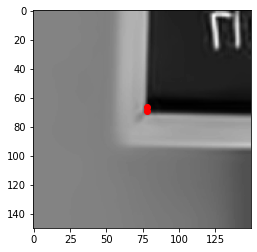

train/recortada6.1.jpg


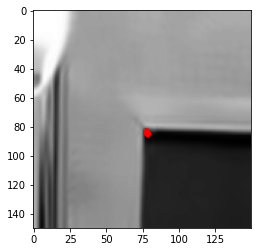

train/recortada61.1.jpg


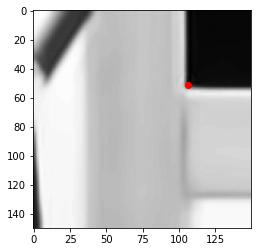

train/recortada52.jpg


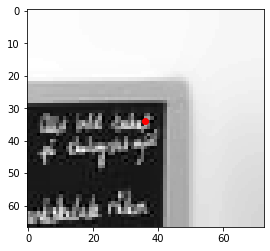

train/recortada34.jpg


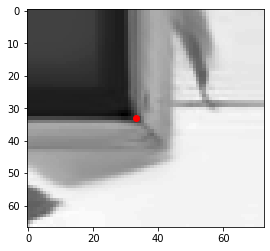

train/recortada71.jpg


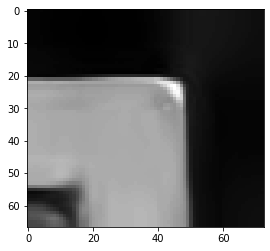

train/recortada24.1.jpg


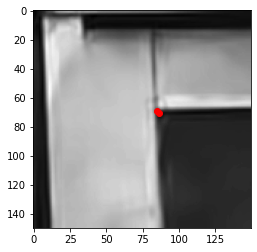

train/recortada29.2.jpg


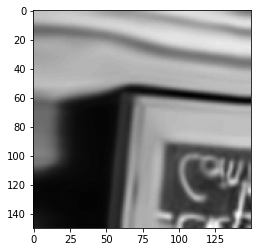

train/recortada21.jpg


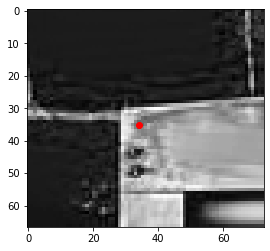

train/recortada57.jpg


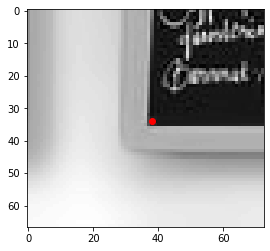

train/recortada73.jpg


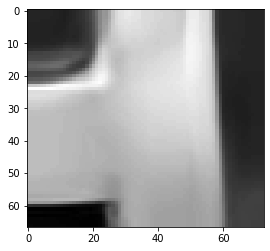

train/recortada80.jpg


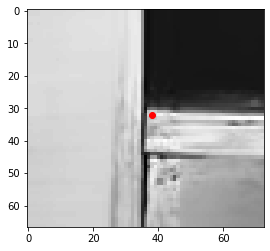

train/recortada83.jpg


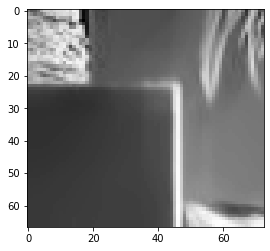

train/recortada8.jpg


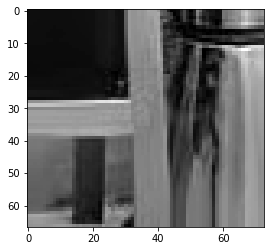

train/recortada53.1.jpg


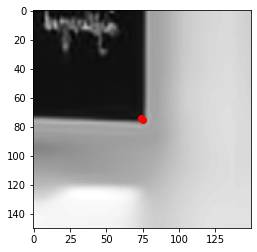

train/recortada1.jpg


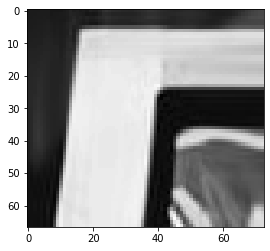

train/recortada99.jpg


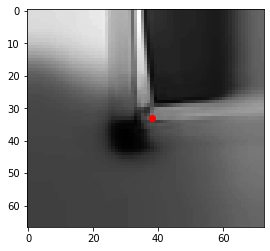

train/recortada55.jpg


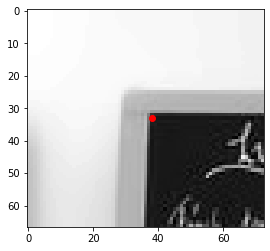

train/recortada30.1.jpg


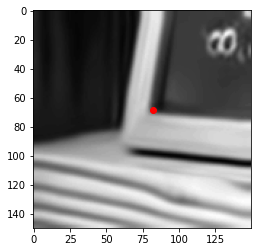

train/recortada50.jpg


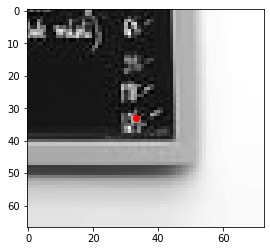

train/recortada87.jpg


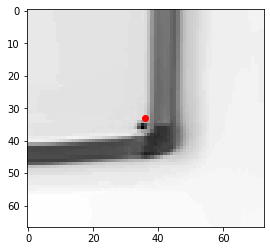

train/recortada66.jpg


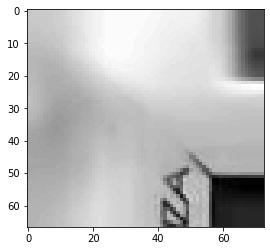

train/recortada43.jpg


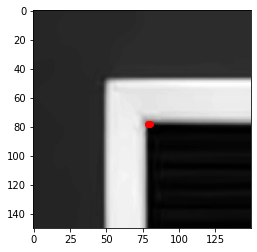

train/recortada6.3.jpg


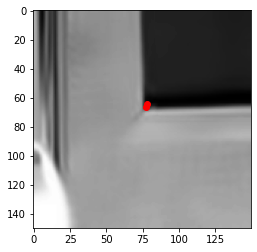

train/recortada75.jpg


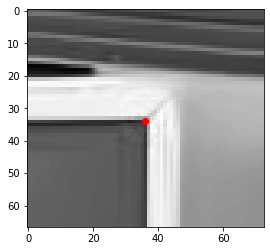

train/recortada39.1.jpg


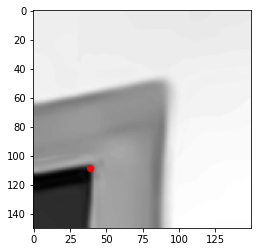

train/recortada35.jpg


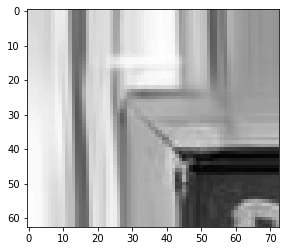

train/recortada45.jpg


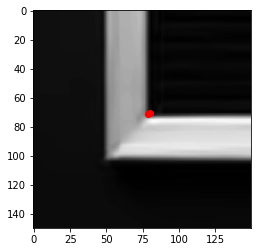

train/recortada54.jpg


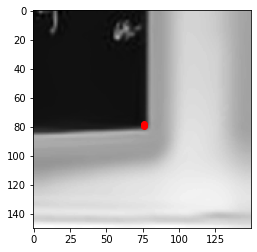

train/recortada76.jpg


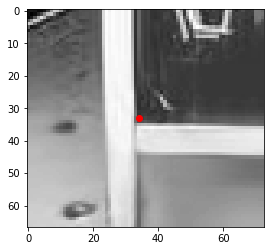

train/recortada53.3.jpg


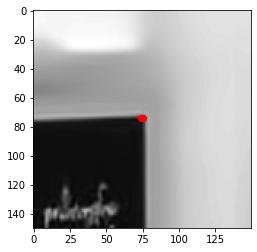

train/recortada16.jpg


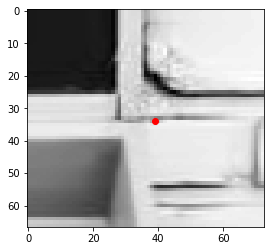

train/recortada89.jpg


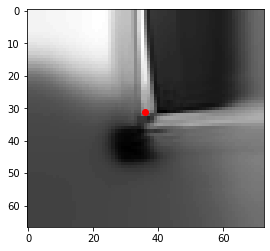

train/recortada63.3.jpg


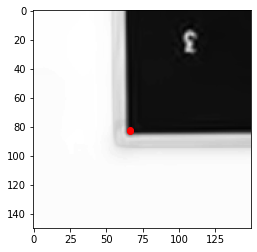

train/recortada94.jpg


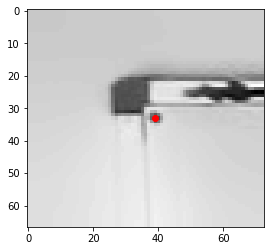

train/recortada30.2.jpg


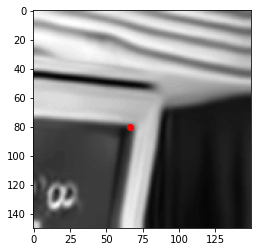

train/recortada19.jpg


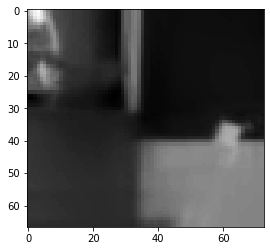

train/recortada22.jpg


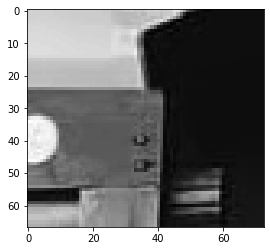

train/recortada93.jpg


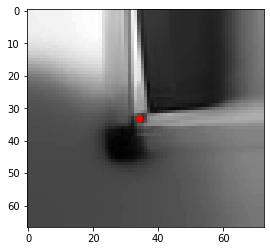

train/recortada31.3.jpg


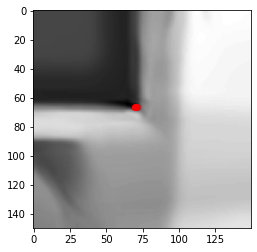

train/recortada46.jpg


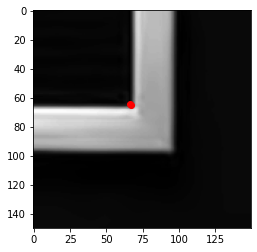

train/recortada51.3.jpg


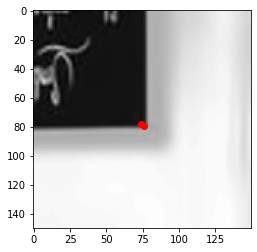

train/recortada43.1.jpg


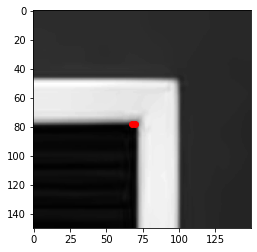

train/recortada54.2.jpg


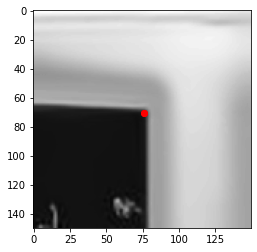

train/recortada40.jpg


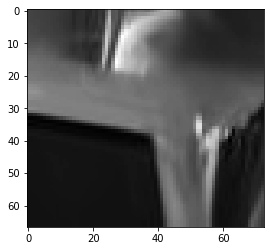

train/recortada9.jpg


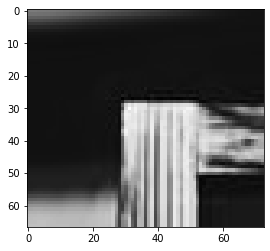

train/recortada25.jpg


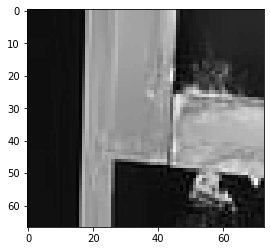

train/recortada72.jpg


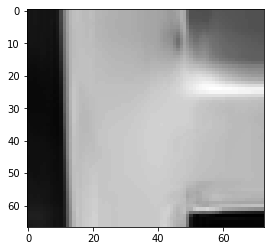

train/recortada53.2.jpg


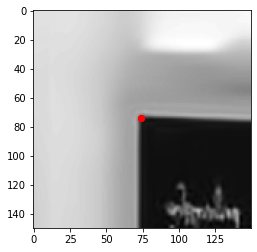

train/recortada45.2.jpg


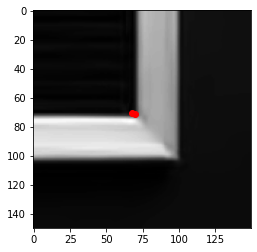

train/recortada61.3.jpg


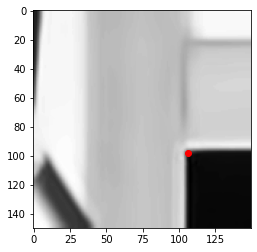

train/recortada32.jpg


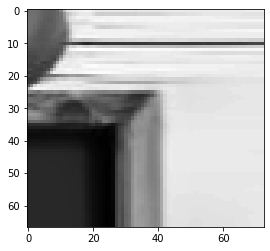

train/recortada37.jpg


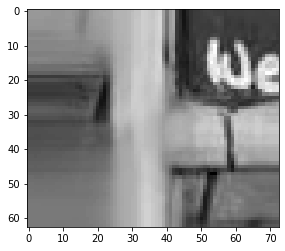

train/recortada39.jpg


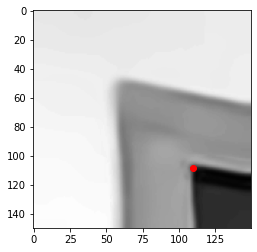

train/recortada10.jpg


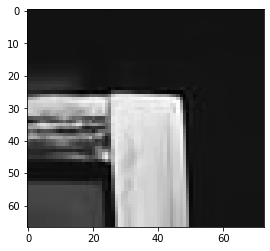

train/recortada63.jpg


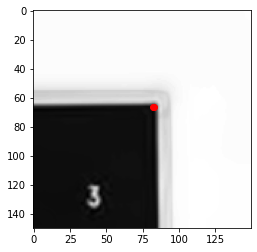

train/recortada45.3.jpg


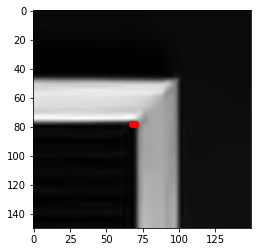

train/recortada29.1.jpg


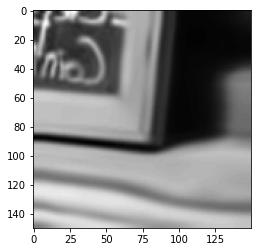

train/recortada47.jpg


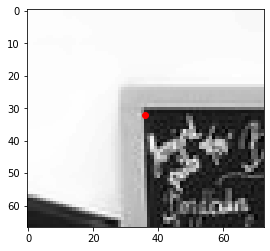

train/recortada27.jpg


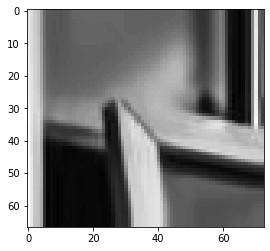

train/recortada49.jpg


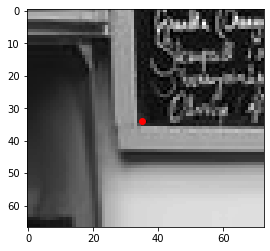

train/recortada65.3.jpg


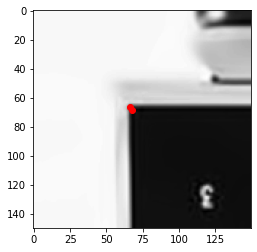

train/recortada60.jpg


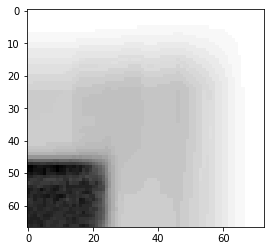

train/recortada81.jpg


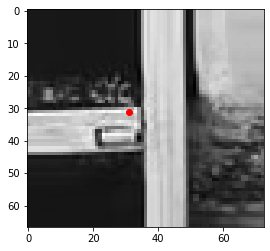

train/recortada85.jpg


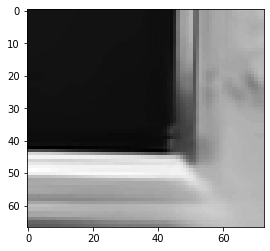

train/recortada30.3.jpg


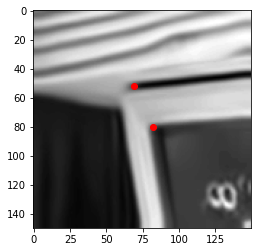

train/recortada18.jpg


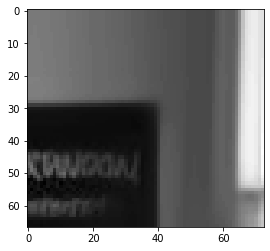

train/recortada5.3.jpg


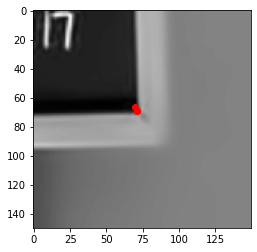

train/recortada26.jpg


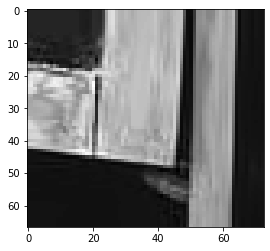

train/recortada33.jpg


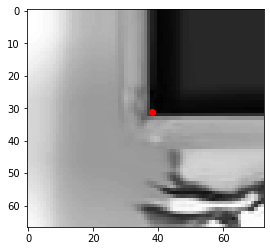

train/recortada74.jpg


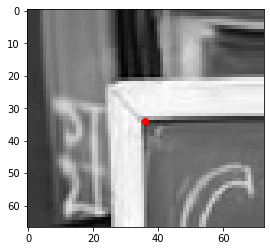

train/recortada91.jpg


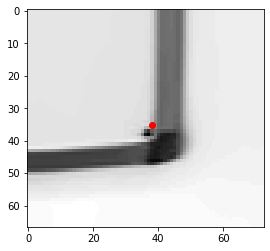

train/recortada36.jpg


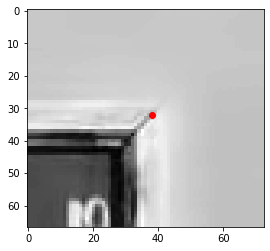

train/recortada88.jpg


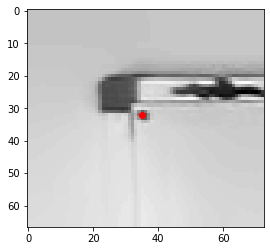

train/recortada4.jpg


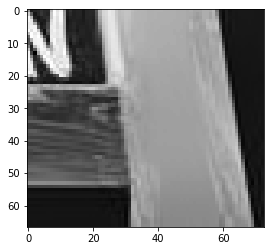

train/recortada90.jpg


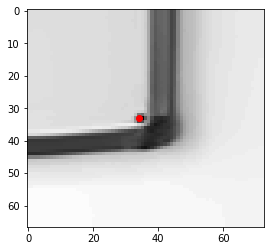

train/recortada68.jpg


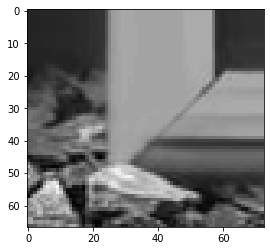

train/recortada61.jpg


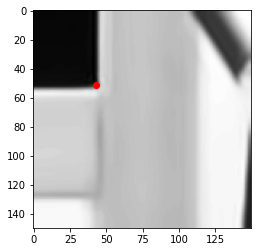

train/recortada63.2.jpg


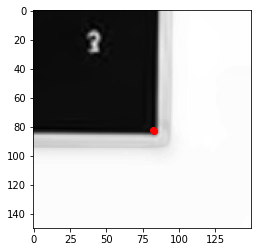

train/recortada17.jpg


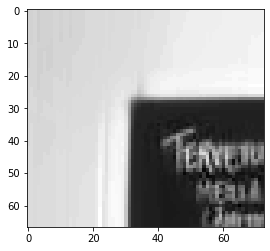

train/recortada62.jpg


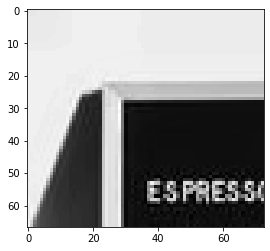

train/recortada38.jpg


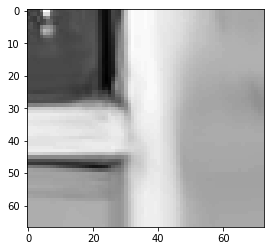

train/recortada53.jpg


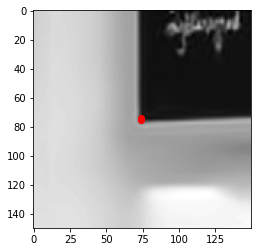

train/recortada65.jpg


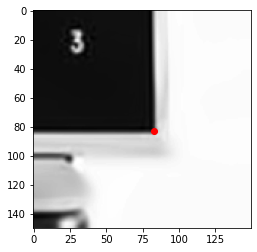

train/recortada97.jpg


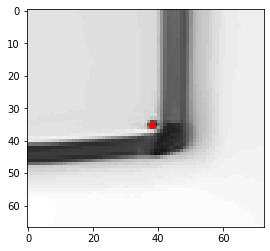

train/recortada77.jpg


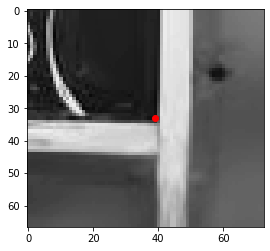

train/recortada41.jpg


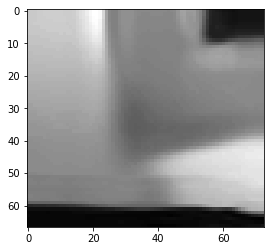

train/recortada24.3.jpg


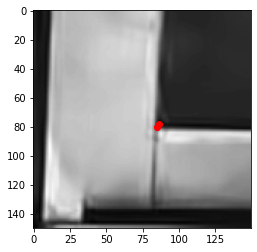

train/recortada46.1.jpg


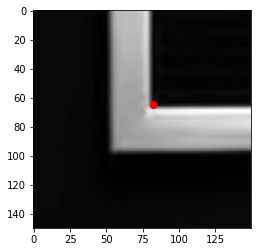

train/recortada20.jpg


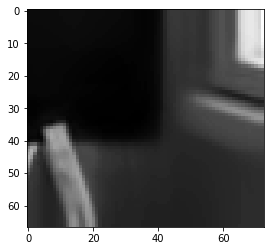

train/recortada44.1.jpg


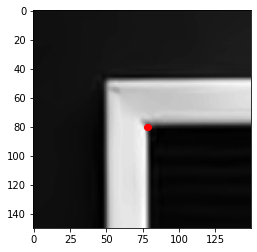

train/recortada95.jpg


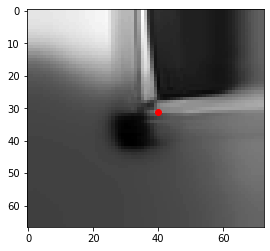

train/recortada70.jpg


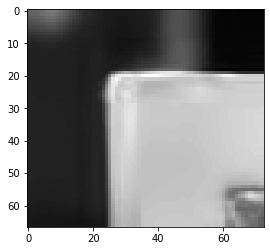

train/recortada51.jpg


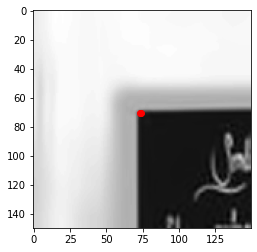

train/recortada79.jpg


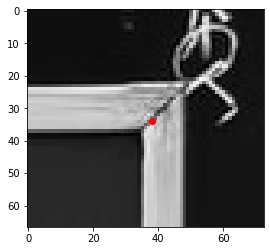

train/recortada54.1.jpg


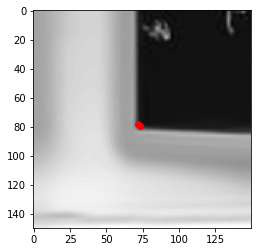

train/recortada100.jpg


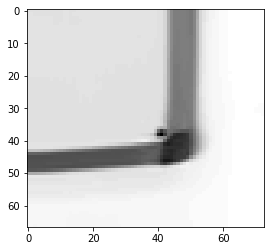

train/recortada29.jpg


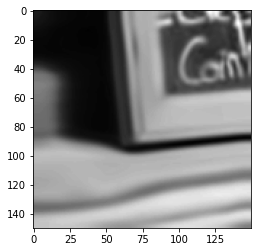

train/recortada69.jpg


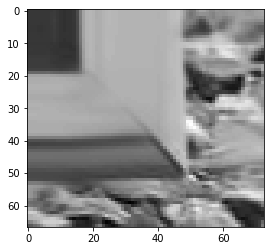

train/recortada98.jpg


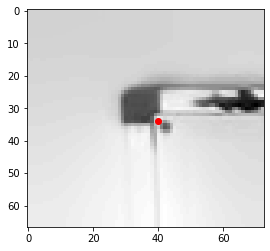

train/recortada31.jpg


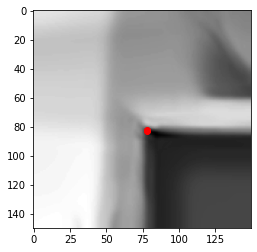

train/recortada6.jpg


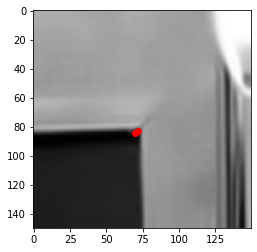

Entrenamiento completado


In [4]:
directory = os.fsencode(r'train')
contimg = 0
for entry in os.scandir(directory):
  estructura = []  # Estructura dada para almacenar keypoints de cada imagen
  ruta  = entry.path.decode("utf-8")
  img = cv.imread(ruta)
  dst = cv.fastNlMeansDenoisingColored(img,10,10,7,21)
  gray = cv.cvtColor(dst, cv.COLOR_BGR2GRAY)


  orb = cv.ORB_create(nfeatures=2,scaleFactor=2,nlevels=2) #n features el numero de keypoints nfeatures=2,scaleFactor=1.3,nlevels=2
  kp, des = orb.detectAndCompute(gray, None)
  descriptores.append(des) #funcion que almacena datos del keypoint en la lista
  h, w= gray.shape
  rellenarEstructura(kp,estructura)   #funcion que almacena datos del keypoint en la lista
  diccionario[contimg] = estructura
  contimg = contimg + 1
  print(ruta)
  plt.imshow(gray,cmap="gray")
  plt.show()
print("Entrenamiento completado")
flann.add(descriptores)


In [51]:
def enderezarHorizontal(imagen):
  gray = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
  gray = cv.bitwise_not(gray)

  # Aplicarle un threshold para dejarla binaria
  # (los pixels serán 0 ó 255)
  binaria = cv.threshold(gray, 0, 255,
                  cv.THRESH_BINARY | cv.THRESH_OTSU)[1]


  # Usar la transformada de Hough para encontrar líneas
  # en la imagen binarizada, con una resolución de medio
  # grado (pi/720) y quedándose sólo con las líneas que
  # alcancen puntuación de 1000 o más (que serán las
  # más largas)
  lineas = cv.HoughLines(binaria, 1, np.pi/720, 1000)

  # Recopilemos qué ángulos ha encontrado la transformada
  # de hough para cada una de las líneas halladas
  angulos = []
  if isinstance(lineas, Iterable):
    for linea in lineas:
        theta = linea[0][1]
        angulos.append(theta)

    # Ahora contemos cuántas veces aparece cada ángulo
    from collections import Counter
    veces = Counter(angulos)

    # Y quedémonos con el ángulo que más veces se repite
    angulo = veces.most_common()[0][0]

    # Cambiar el sentido de la rotación si el ángulo es mayor de 180º
    if angulo > np.pi/2:
      angulo = -angulo

    # Ahora enderecemos la imagen, girando (en negativo) el ángulo detectado
    (h, w) = imagen.shape[:2]
    centro = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(centro, angulo, 1.0)

    girada = cv.warpAffine(imagen, M, (w, h),
                  flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

    # Y volcamos a disco el resultado
    return girada

In [52]:
def rellenarMatrizAcumulacion(kp1,m,img1,lineas,puntos,PuntosClave,points):
  xImagen, yImagen,zImagen = img.shape

  p1x= kp1[m.queryIdx].pt[0]
  p1y = kp1[m.queryIdx].pt[1]
  sizeAc= kp1[m.queryIdx].size
  sizeDicc = diccionario[m.imgIdx][m.trainIdx][1]
  size = sizeAc / sizeDicc
  modulo = diccionario[m.imgIdx][m.trainIdx][3]
  angulo = diccionario[m.imgIdx][m.trainIdx][4] + diccionario[m.imgIdx][m.trainIdx][2] - kp1[m.queryIdx].angle
  cX = (modulo * math.cos(angulo)) * size
  cY = (modulo * math.sin(angulo)) * size
  x = int((p1x + cX) // 10)
  y = int((p1y + cY) // 10)
  if ((x > 0) and (x < yImagen // 10) and (y > 0) and (y < xImagen // 10)):
    for i in lineas:
      x1 = i[0][0]
      y1 = i[0][1]
      x2 = i[1][0]
      y2 = i[1][1]
      a, b = ecuacion(x1,y1,x2,y2,x*10,y*10) # Esto funciona regular
      if (a-b)>-5 and (a-b)<5:
        #plt.plot(x*10,y*10, marker="o", color="red")
        points.append([x*10,y*10])
        for i  in puntos:
          if (x*10-i[0])>-10 and (x*10-i[0])<10 and (y*10-i[1])>-10 and (y*10-i[1])<10:
            PuntosClave.append([x*10,y*10])
            plt.plot(x*10,y*10, marker="o", color="blue")
            break

In [53]:
def pintarLineas(color,edges_img,lineas,tope): 
  xImagen,yImagen = color.shape
  lines = cv.HoughLines(edges_img,1,np.pi/180,100,250)
  if isinstance(lines, Iterable):
    for line in lines:
      if tope == 0:
        break
      rho,theta = line[0]
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a*rho
      y0 = b*rho
      x1 = int(x0 + 1000*(-b))
      y1 = int(y0 + 1000*(a))
      x2 = int(x0 - 1000*(-b))
      y2 = int(y0 - 1000*(a))

      cv.line(color,(x1,y1),(x2,y2),(0,0,255),4)
      lineas.append([(x1,y1),(x2,y2)])
      tope -= 1


In [54]:
def gradiente(x1,y1,x2,y2):
  if ((x2-x1) == 0 ):
    return x2 
  return int((y2-y1)/(x2-x1))

In [55]:
def ecuacion(x1,y1,x2,y2,x,y):
  #y - y0  = m(x-x0) 
  m = gradiente(x1,y1,x2,y2)
  b = (-m * x1) + y1
  x = x * m + b
  return x,y

In [56]:
def puntosDeInteres(img,lineas,puntosPosibles,PuntosClave,points):  
  orb = cv.ORB_create() 
  kp1, des1 = orb.detectAndCompute(img, None)
  matches = flann.knnMatch(des1, k=2)

  for r in matches:
    for m in r:
      rellenarMatrizAcumulacion(kp1,m,color,lineas,puntosPosibles,PuntosClave,points)

In [57]:
def valorX(m1,b1,m2,b2):
  m = m1-m2
  b = b2-b1
  if m < 0:
    m = -1*m
    b = -1*b
  if m == 0:
    return 0
  return int(b/m)

In [58]:
def puntosDeCorte(img,lineas,puntos):
  xImagen, yImagen = img.shape
  for i in lineas: 
    x1 = i[0][0]
    y1 = i[0][1]
    x2 = i[1][0]
    y2 = i[1][1]
    m1 = gradiente(x1,y1,x2,y2)
    b1 = (-m1 * x1) + y1
    for j in lineas:
      if j == i:
        continue
      px1 = j[0][0]
      py1 = j[0][1]
      px2 = j[1][0]
      py2 = j[1][1]
      m2 = gradiente(px1,py1,px2,py2)
      b2 = (-m2 * px1) + py1
      x = valorX(m1,b1,m2,b2)
      y = (m1 * x) + b1
      if ((x > 0) and (x < yImagen) and (y > 0) and (y < xImagen)):
        puntos.append([int(x),int(y)])

In [68]:
def detectorPizarra(puntosClave,color,points):
  if len(puntosClave)>4:
    puntosClave.sort()
    x1 = puntosClave[0][0]
    y1 = puntosClave[0][0]
    x2 = puntosClave[len(puntosClave)-1][0]
    y2 = puntosClave[len(puntosClave)-1][1]
    return x1,y1,x2,y2
  if len(puntosClave) == 0:
    points.sort()
    x1 = points[0][0]
    y1 = points[0][1]
    x2 = points[len(points)-1][0]
    y2 = points[len(points)-1][1]
    return x1,y1,x2,y2
  else:
    contours, hierarchy = cv.findContours(color, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    c = max(contours, key = cv.contourArea)
    x,y,w,h = cv.boundingRect(c)
    x1 = x
    y1 = y
    x2 = x+w
    y2 = y+h

  return x1,y1,x2,y2

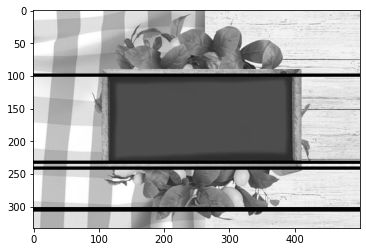

100 100 420 230


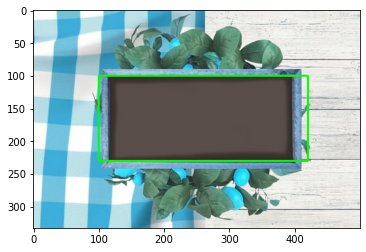

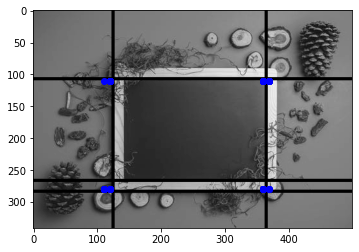

110 110 370 280


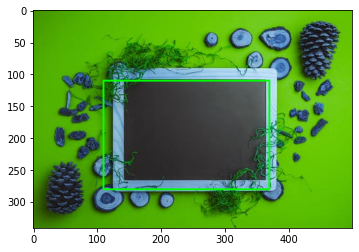

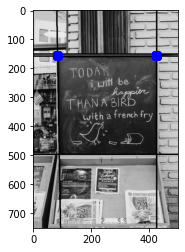

80 80 430 160


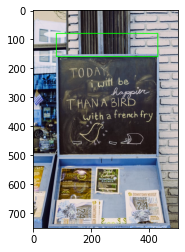

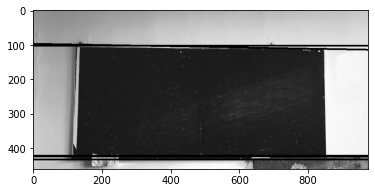

100 100 910 430


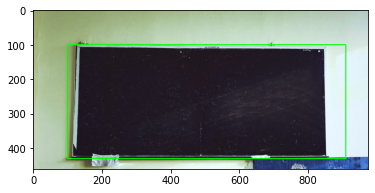

In [ ]:
directory = os.fsencode(r'test')
for entry in os.scandir(directory):
  lineas = [] #lineas de la imagen
  puntosCorte = [] #puntos de contre entre lineas
  puntosClave = [] #recuadro de pizarra
  points = [] #coordenadas de keypoint
  ruta = entry.path.decode("utf-8")
  img = cv.imread(ruta)
  #filtros
  #img1 = enderezarHorizontal(img)
  dst = cv.fastNlMeansDenoisingColored(img,20,20,7,21) #Reducimos el ruido de la foto para que solo se vea casi el marco y poco mas
  color = cv.cvtColor(dst, cv.COLOR_BGR2GRAY)
  edges_img = cv.Canny(color,50,150,apertureSize = 3)

  #lineas
  color = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  pintarLineas(color,edges_img,lineas,5) #El numero de lineas maximo que quiero sacar

  # find the biggest countour (c) by the area
  #contours, hierarchy = cv.findContours(color, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
  #c = max(contours, key = cv.contourArea)
  #x,y,w,h = cv.boundingRect(c)

  # draw the biggest contour (c) in green
  #cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

  #plt.imshow(img,cmap="gray")
 # plt.show()

  puntosDeCorte(color,lineas,puntosCorte)

  puntosDeInteres(color,lineas,puntosCorte,puntosClave,points)
  plt.imshow(color,cmap="gray")
  plt.show()

  x1,y1,x2,y2 = detectorPizarra(puntosClave,color,points) # estos puntos son buenos

  print(x1,y1,x2,y2)
  cv.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)

  plt.imshow(img,cmap="gray")
  plt.show()